# CRM Analitiği

### Kohort Analizi - Python Uygulama

In [1]:
# Kütüphane aktivasyonları
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import warnings
import matplotlib
import squarify
from datetime import datetime
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

In [2]:
# Görünürlük ayarları
warnings.simplefilter('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.width', 500)

In [3]:
# Verinin import edilmesi
def online_retail(path,sheetname):
    dataframe = pd.read_excel(path, sheet_name = sheetname)
    return dataframe

In [4]:
df_ = online_retail("online_retail_II.xlsx","Year 2010-2011")

In [5]:
df = df_.copy()

In [6]:
# Veriye genel bakış
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    
check_df(df,head=5)

##################### Shape #####################
(541910, 8)
##################### Types #####################
Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object
##################### Head #####################
  Invoice StockCode                          Description  Quantity         InvoiceDate  Price  Customer ID         Country
0  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6 2010-12-01 08:26:00  2.550    17850.000  United Kingdom
1  536365     71053                  WHITE METAL LANTERN         6 2010-12-01 08:26:00  3.390    17850.000  United Kingdom
2  536365    84406B       CREAM CUPID HEARTS COAT HANGER         8 2010-12-01 08:26:00  2.750    17850.000  United Kingdom
3  536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6 2010-12-01 08:26:00  3.390

In [7]:
# Veri ön işleme
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


def online_retail_data_prep(dataframe):
    dataframe.dropna(inplace=True)
    dataframe = dataframe[~dataframe["Invoice"].str.contains("C", na=False)]
    dataframe = dataframe[dataframe["Quantity"] > 0]
    dataframe = dataframe[dataframe["Price"] > 0]
    replace_with_thresholds(dataframe, "Quantity")
    replace_with_thresholds(dataframe, "Price")
    dataframe["TotalPrice"] = dataframe["Quantity"] * dataframe["Price"]
    return dataframe

df = online_retail_data_prep(df)

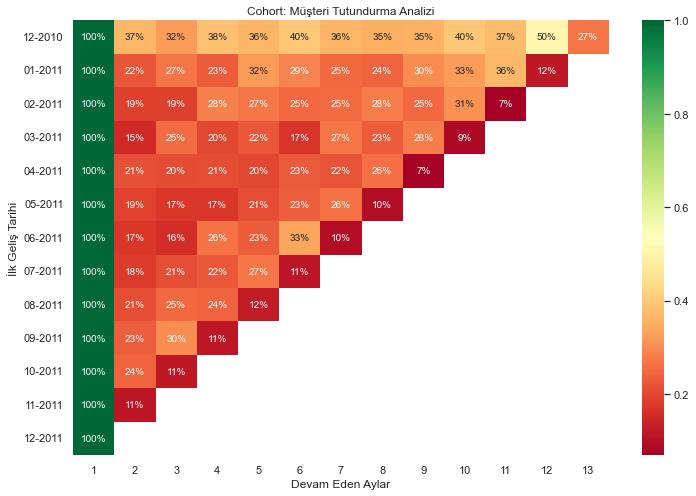

In [8]:
# Kohort Analizi
def cohort_analysis(df,plot=False):
    df = df[['InvoiceDate','Customer ID','TotalPrice']]
    # tarih için sadece yıl ve ay bilgilerinin getirilmesi
    get_year_month = lambda x: datetime(x.year, x.month, 1)
    # lambda fonksiyonun veriye uygulanması
    df['OrderMonth'] = df['InvoiceDate'].apply(get_year_month)
    # kullanıcıların ilk sipariş tarihini getirelim
    user_first_date = df.groupby('Customer ID')['OrderMonth']
    df['CohortMonth'] = user_first_date.transform('min')
    # ilk sipariş ve sonraki sipariş arası farklar
    # yıl farkı
    years_diff = df['OrderMonth'].dt.year - df['CohortMonth'].dt.year
    # ay farkı
    months_diff = df['OrderMonth'].dt.month - df['CohortMonth'].dt.month
    # aradaki farkın yeni kolona eklenmesi
    df['CohortIndex'] = years_diff * 12 + months_diff + 1
    grouping_count = df.groupby(['CohortMonth', 'CohortIndex'])
    cohort_data = grouping_count['Customer ID'].apply(pd.Series.nunique)
    cohort_data = cohort_data.reset_index()
    cohort_user_counts = cohort_data.pivot(index='CohortMonth',
                                  columns='CohortIndex',
                                  values='Customer ID')
    
    if plot:
        # her bir müşteri için aktiflik yüzdesinin oluşturulması
        cohort_sizes = cohort_user_counts.iloc[:,0]
        retention = cohort_user_counts.divide(cohort_sizes, axis=0)

        # cohort formatının ay ve yıl olarak gösterimi
        retention.index = retention.index.strftime('%m-%Y')

        # cohort
        sns.set(style = 'white')
        plt.figure(figsize = (12, 8))
        plt.title('Cohort: Müşteri Tutundurma Analizi')
        sns.heatmap(
                    retention
                    ,cmap = 'RdYlGn'
                    ,annot = True
                    ,fmt = '.0%'
                    )
        plt.xlabel("Devam Eden Aylar")
        plt.ylabel("İlk Geliş Tarihi")
        plt.show(block=True)
        
cohort_analysis(df,plot = True)

### RFM Analizi - Python Uygulama

#################### RFM Analysis ########################################
                    recency       frequency       monetary      
                       mean count      mean count     mean count
segment                                                         
about_to_sleep       53.312   352     1.162   352  469.058   352
at_risk             153.786   593     2.877   593  938.458   593
cant_loose          132.968    63     8.381    63 2646.823    63
champions             6.362   633    12.414   633 6498.641   633
hibernating         217.605  1071     1.102  1071  398.573  1071
loyal_customers      33.608   819     6.480   819 2752.520   819
need_attention       52.428   187     2.326   187  847.657   187
new_customers         7.429    42     1.000    42  314.884    42
potential_loyalists  17.399   484     2.010   484  674.628   484
promising            23.511    94     1.000    94  285.624    94
###########################################################################


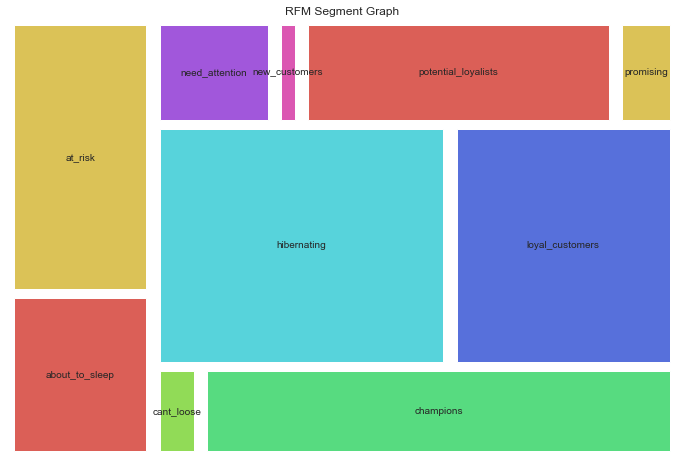

In [9]:
def create_rfm(dataframe, csv=False, plot = False):
    
    # RFM Metriklerinin Hesaplanması
    # Analiz edilecek tarih (Genel olarak veride yer alan en yakın tarihin 1-2 gün uzağındaki tarih.)
    # df.InvoiceDate.max()/Timestamp('2011-12-09 12:50:00')
    today_date = dt.datetime(2011, 12, 11)
    rfm = dataframe.groupby('Customer ID').agg({'InvoiceDate': lambda date: (today_date - date.max()).days, # Recency değeri hesaplanması
                                                'Invoice': lambda num: num.nunique(), # Frequency değeri hesaplanması
                                                "TotalPrice": lambda price: price.sum()}) # Monetary değeri hesaplanması
    
    # rfm nesnesinde yer alan kolon isimlerini uyarlama
    rfm.columns = ['recency', 'frequency', "monetary"]
    rfm = rfm[(rfm['monetary'] > 0)]

    # RFM skorlarının standartlaştırılması
    rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1]) # Sayısal değeri az olan daha önemli.
    rfm["frequency_score"] = pd.qcut(rfm["frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5]) # Sayısal değeri an olan daha az önemli
    rfm["monetary_score"] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5]) # Sayısal değeri an olan daha az önemli

    # RFM skorlarının kategorik değere dönüştürülüp df'e eklendi
    rfm["RFM_SCORE"] = (rfm['recency_score'].astype(str) +
                        rfm['frequency_score'].astype(str))


    # Segmentlerin isimlendirilmesi
    seg_map = {
        r'[1-2][1-2]': 'hibernating',
        r'[1-2][3-4]': 'at_risk',
        r'[1-2]5': 'cant_loose',
        r'3[1-2]': 'about_to_sleep',
        r'33': 'need_attention',
        r'[3-4][4-5]': 'loyal_customers',
        r'41': 'promising',
        r'51': 'new_customers',
        r'[4-5][2-3]': 'potential_loyalists',
        r'5[4-5]': 'champions'
    }

    rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)
    rfm = rfm[["recency", "frequency", "monetary", "segment"]]
    rfm.index = rfm.index.astype(int)
    print("#################### RFM Analysis ########################################")
    print(rfm.groupby("segment").agg(["mean", "count"]))
    print("###########################################################################")
    
    if csv:
        rfm.to_csv("rfm.csv")
        
    if plot:
        rfm.reset_index(inplace=True)
        segment_groups = rfm.groupby("segment")["Customer ID"].nunique().reset_index()
        cmap = matplotlib.cm.coolwarm
        colors = sns.color_palette("hls", 8)
        mini = min(segment_groups["Customer ID"])
        maxi = max(segment_groups["Customer ID"])
        norm = matplotlib.colors.Normalize(vmin=mini,vmax=maxi)
        fig = plt.gcf()
        ax = fig.add_subplot()
        fig.set_size_inches(12,8)
        squarify.plot(sizes=segment_groups["Customer ID"],
                      label = segment_groups.segment,
                      alpha=1,
                      pad=True,
                      color=colors)
        plt.title("RFM Segment Graph",)
        plt.axis("off")
        plt.show(block=True)

    return rfm

rfm_new = create_rfm(df, csv=False,plot = True)

###  Müşteri Yaşam Boyu Değeri - Python Uygulama

In [10]:
def create_cltv_c(dataframe, profit=0.10):
    # CLTV hesaplamaları için müşterileri tekilleştirme işlemleri:
    cltv_c = dataframe.groupby('Customer ID').agg({'Invoice': lambda x: x.nunique(), # İşlemlerin müşteri bazlı tekilleştirilmesi
                                                   'Quantity': lambda x: x.sum(), # İşlemlerin toplam niceliklerinin müşteri bazlı toplamı
                                                   'TotalPrice': lambda x: x.sum()}) # İşlemlerin toplam ücretinin müşteri bazlı tekilleştirilmesi
   
    # cltv_c kolonlarının kolon bazlı olarak isimlerinin değiştirilmesi
    cltv_c.columns = ['total_transaction', 'total_unit', 'total_price']
    # avg_order_value (Ortalama Sipariş Değeri = Toplam Fiyat / Toplam İşlem)
    cltv_c['avg_order_value'] = cltv_c['total_price'] / cltv_c['total_transaction']
    # purchase_frequency (Satın Alma Sıklığı = Toplam İşlem / Toplam Müşteri Sayısı)
    cltv_c["purchase_frequency"] = cltv_c['total_transaction'] / cltv_c.shape[0]
    # repeat rate (Tekrarlanan Sipariş Oranı (Birden fazla alışveriş yapan müşteri sayısı / Tüm müşteriler))
    repeat_rate = cltv_c[cltv_c.total_transaction > 1].shape[0] / cltv_c.shape[0]
    # churn rate (Müşteri Terk Oranı = 1 - Tekrarlanan Sipariş Oranı) 
    churn_rate = 1 - repeat_rate
    # profit_margin (Kâr Marjı = Toplam Fiyat * (profit))
    cltv_c['profit_margin'] = cltv_c['total_price'] * profit
    # Customer Value (Müşteri Değeri = Ortalama Sipariş Değeri * Satın Alma Sıklığı)
    cltv_c['customer_value'] = (cltv_c['avg_order_value'] * cltv_c["purchase_frequency"])
    # Customer Lifetime Value ((Customer Value/ Churn Rate)* Profit Margin)
    cltv_c['cltv'] = (cltv_c['customer_value'] / churn_rate) * cltv_c['profit_margin']
    # Segment
    cltv_c["segment"] = pd.qcut(cltv_c["cltv"], 4, labels=["D", "C", "B", "A"])
    print("#################### CLV Analysis ########################################")
    print(cltv_c.groupby("segment").agg(["mean", "count"]).T)
    print("###########################################################################")

    return cltv_c

clv = create_cltv_c(df)

#################### CLV Analysis ########################################
segment                         D        C        B         A
total_transaction  mean     1.270    1.855    3.501    10.459
                   count 1085.000 1084.000 1084.000  1085.000
total_unit         mean   116.656  278.221  636.912  3307.567
                   count 1085.000 1084.000 1084.000  1085.000
total_price        mean   175.420  456.043 1052.800  5882.376
                   count 1085.000 1084.000 1084.000  1085.000
avg_order_value    mean   151.552  300.896  393.571   610.424
                   count 1085.000 1084.000 1084.000  1085.000
purchase_frequency mean     0.000    0.000    0.001     0.002
                   count 1085.000 1084.000 1084.000  1085.000
profit_margin      mean    17.542   45.604  105.280   588.238
                   count 1085.000 1084.000 1084.000  1085.000
customer_value     mean     0.040    0.105    0.243     1.356
                   count 1085.000 1084.000 1084.000  1085

### Müşteri Yaşam Boyu Değeri Tahmini - Python Uygulama

In [11]:
def create_cltv_p(dataframe, month=3,week = 4):
    # df.InvoiceDate.max()/Timestamp('2011-12-09 12:50:00')
    today_date = dt.datetime(2011, 12, 11)

    cltv_df = dataframe.groupby('Customer ID').agg(
        {'InvoiceDate': [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days, # recency
                         lambda InvoiceDate: (today_date - InvoiceDate.min()).days], # T
         'Invoice': lambda Invoice: Invoice.nunique(), # frequency
         'TotalPrice': lambda TotalPrice: TotalPrice.sum()}) # monetary

    cltv_df.columns = cltv_df.columns.droplevel(0)
    cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']
    cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]
    cltv_df = cltv_df[(cltv_df['frequency'] > 1)]
    cltv_df["recency"] = cltv_df["recency"] / 7 # haftalık
    cltv_df["T"] = cltv_df["T"] / 7 # haftalık

    # 2. BG-NBD Modelinin Kurulması
    bgf = BetaGeoFitter(penalizer_coef=0.001)
    bgf.fit(cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T'])

    cltv_df["expected_purc_"+str(week)+"_week"] = bgf.predict(week,
                                                  cltv_df['frequency'],
                                                  cltv_df['recency'],
                                                  cltv_df['T'])


    # 3. GAMMA-GAMMA Modelinin Kurulması
    ggf = GammaGammaFitter(penalizer_coef=0.01)
    ggf.fit(cltv_df['frequency'], cltv_df['monetary'])
    cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                                 cltv_df['monetary'])

    # 4. BG-NBD ve GG modeli ile CLTV'nin hesaplanması.
    cltv = ggf.customer_lifetime_value(bgf,
                                       cltv_df['frequency'],
                                       cltv_df['recency'],
                                       cltv_df['T'],
                                       cltv_df['monetary'],
                                       time=month,  # 3 aylık
                                       freq="W",  # T'nin frekans bilgisi.
                                       discount_rate=0.01)

    cltv = cltv.reset_index()
    cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")
    cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])
    print("#################### BG/NBD - Gamma Gamma CLTV Analysis ########################################")
    print(cltv_final.groupby("segment").agg({"count", "mean"}).T)
    print("###########################################################################")

    return cltv_final


cltv_final2 = create_cltv_p(df)

#################### BG/NBD - Gamma Gamma CLTV Analysis ########################################
segment                               D         C         B         A
Customer ID             count   712.000   711.000   711.000   711.000
                        mean  15558.476 15309.634 15352.819 14947.359
recency                 count   712.000   711.000   711.000   711.000
                        mean     22.074    30.670    29.515    31.411
T                       count   712.000   711.000   711.000   711.000
                        mean     40.465    38.111    34.812    34.484
frequency               count   712.000   711.000   711.000   711.000
                        mean      3.065     4.096     5.442    11.359
monetary                count   712.000   711.000   711.000   711.000
                        mean    183.963   271.695   373.443   659.859
expected_purc_4_week    count   712.000   711.000   711.000   711.000
                        mean      0.283     0.480     0.647    

## Kaynaklar

- https://towardsdatascience.com/a-step-by-step-introduction-to-cohort-analysis-in-python-a2cbbd8460ea
- https://towardsdatascience.com/an-rfm-customer-segmentation-with-python-cf7be647733d
- https://towardsdatascience.com/measuring-customers-value-using-python-lifetimes-d8b19a04e9c1
- https://medium.com/analytics-vidhya/the-gamma-distribution-and-its-applications-in-the-mobile-app-industry-2ba891d8b7f4
- https://www.miuul.com/not-defteri/power-bi-ile-crm-analitigi-i-kohort-analizi
- https://www.miuul.com/not-defteri/power-bi-ile-crm-analitigi-ii-rfm-ile-musteri-segmentasyonu
- https://www.miuul.com/not-defteri/power-bi-ile-crm-analitigi-iii-cltv-ile-musteri-segmenti-olusturma
- https://www.miuul.com/not-defteri/power-bi-ile-crm-analitigi-iv-musteri-yasam-boyu-degeri-tahmini
- https://www.miuul.com/not-defteri/sql-serverda-t-sql-ile-rfm-analizi
- https://www.veribilimiokulu.com/3-adimda-crm-musteri-iliskileri-yonetimi/